Evaluation (for GloVe-CNN)

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import pickle

In [2]:
import sys
 
# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

import evaluation_functions


SAVE_EVAL_RESULTS = True
SAVE_NUMPY_ARRAYS = True
LOAD_NUMPY_ARRAYS = False

In [3]:
# import importlib
# importlib.reload(evaluation_functions)

In [170]:
DATASET_SIZE = 480
DATASET_IS_BALANCED = False


MAX_FEATURES = 20000        # max_features params for CountVectorizer

training_name = 'glove-cnn-{}_{}k_{}'.format(
    MAX_FEATURES,
    DATASET_SIZE,
    'bal' if DATASET_IS_BALANCED else 'imbal'
)

training_args_datetime = datetime(year=2023, month=12, day=20)
training_storing_folder = Path(training_name).resolve()

In [171]:
# rerun this cell if want to evaluate a new model

X_train, X_test, y_train, y_test = dataset_loader.load_presampled_traintest_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

Loaded dataset size: 480k, is_balanced: False

Training dataset class distribution
review_score
1    360011
0     71989
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    39989
0     8011
Name: count, dtype: int64





In [41]:
# load validation dataset. Same for all models

X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_validation_dataset()

Loaded validation dataset

Validation dataset imbalanced class distribution
review_score
1    774377
0    150928
Name: count, dtype: int64
Validation dataset balanced class distribution
review_score
0    150672
1    150672
Name: count, dtype: int64





In [8]:
# data cleaning function
# same as training script

def cleaning_arr(str_arr):
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_num(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_symbols(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_punctuation(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))      # no need to remove stopwords, as previous study shown including stopwords can improve performance (https://aclanthology.org/P12-1092.pdf)
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))


    return str_arr

In [172]:
# rerun this cell if want to evaluate a new model

X_train = cleaning_arr(X_train)
X_test = cleaning_arr(X_test)

# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

In [44]:
# applying data cleaning to all datasets
X_imbal_valid = cleaning_arr(X_imbal_valid)
X_bal_valid = cleaning_arr(X_bal_valid)

# X_bal_valid = X_bal_valid.to_numpy()
# y_bal_valid = y_bal_valid.to_numpy()

# X_imbal_valid = X_imbal_valid.to_numpy()
# y_imbal_valid = y_imbal_valid.to_numpy()

In [173]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
925305
925305

Validation (balanced) set
301344
301344


Validation (imbalanced) set
review_score
1    774377
0    150928
Name: count, dtype: int64

Validation (balanced) set
review_score
0    150672
1    150672
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


---

Load the models

Load the text vectorizer, model itself

Then transform the data through the vectorizer

In [174]:
import pickle

import tensorflow as tf
import keras

text_vectorizer_path = Path.joinpath(training_storing_folder, "{}_{}_textvectorizer.pkl".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
vectorizer_from_disk = pickle.load(open(text_vectorizer_path, 'rb'))
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=512)

vectorizer.set_weights(vectorizer_from_disk['weights'])

model_path = Path.joinpath(training_storing_folder, "{}_{}_model.keras".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
model = keras.models.load_model(model_path)

print('\n\n')
print('Loaded text vectorizer from {}'.format(text_vectorizer_path))
print('Loaded model from {}'.format(model_path))




Loaded text vectorizer from /root/FYP/NLP/dev-workspace/sa/glove-cnn_2023-12-12/glove-cnn-20000_480k_imbal/glove-cnn-20000_480k_imbal_2023-12-20_textvectorizer.pkl
Loaded model from /root/FYP/NLP/dev-workspace/sa/glove-cnn_2023-12-12/glove-cnn-20000_480k_imbal/glove-cnn-20000_480k_imbal_2023-12-20_model.keras


In [175]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 300)             6000600   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 506, 128)             268928    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 506, 128)             268928    ['embedding[0][0]']           
                                                                                              

In [176]:
# create keras dataset object for evaluation
# same as training script

BATCH_SIZE = 128

import tensorflow as tf

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_subset, y_train_subset))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_bal_dataset = tf.data.Dataset.from_tensor_slices((X_bal_valid, y_bal_valid))
valid_imbal_dataset = tf.data.Dataset.from_tensor_slices((X_imbal_valid, y_imbal_valid))

In [177]:
# batch first

test_dataset = test_dataset.batch(BATCH_SIZE)
valid_bal_dataset = valid_bal_dataset.batch(BATCH_SIZE)
valid_imbal_dataset = valid_imbal_dataset.batch(BATCH_SIZE)

In [178]:
# apply text vectorizer to test and validation datasets

test_dataset = test_dataset.map(lambda x, y: (vectorizer(x), y))
valid_bal_dataset = valid_bal_dataset.map(lambda x, y: (vectorizer(x), y))
valid_imbal_dataset = valid_imbal_dataset.map(lambda x, y: (vectorizer(x), y))

In [179]:
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
valid_bal_dataset = valid_bal_dataset.prefetch(tf.data.AUTOTUNE)
valid_imbal_dataset = valid_imbal_dataset.prefetch(tf.data.AUTOTUNE)

---

Evaluation

on test set

In [180]:
# create folders for storing evaluation metrics

eval_metrics_folder = Path.joinpath(training_storing_folder, 'eval_metrics')

if not eval_metrics_folder.exists():
    eval_metrics_folder.mkdir()

eval_test_prefix = 'test'
eval_valid_bal_prefix = 'valid_bal'
eval_valid_imbal_prefix = 'valid_imbal'

eval_test_folder = Path.joinpath(eval_metrics_folder, eval_test_prefix)
eval_valid_bal_folder = Path.joinpath(eval_metrics_folder, eval_valid_bal_prefix)
eval_valid_imbal_folder = Path.joinpath(eval_metrics_folder, eval_valid_imbal_prefix)

if not eval_test_folder.exists():
    eval_test_folder.mkdir()

if not eval_valid_bal_folder.exists():
    eval_valid_bal_folder.mkdir()

if not eval_valid_imbal_folder.exists():
    eval_valid_imbal_folder.mkdir()

In [181]:
if LOAD_NUMPY_ARRAYS:
    y_test_pred_prob_raw = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'))
    y_test_pred = np.load(Path.joinpath(eval_test_folder, 'y_test_pred.npy'))
    y_test_pred_prob = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'))
    y_test = np.load(Path.joinpath(eval_test_folder, 'y_test.npy'))
else:
    y_test_pred_prob_raw = model.predict(test_dataset)

    y_test_pred = np.argmax(y_test_pred_prob_raw, axis=1)

    y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test_pred)) > 2 \
                    else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])

375/375 [==============================] - 2s 4ms/step


In [182]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'), y_test_pred_prob_raw)
    np.save(Path.joinpath(eval_test_folder, 'y_pred.npy'), y_test_pred)
    np.save(Path.joinpath(eval_test_folder, 'y_pred_prob.npy'), y_test_pred_prob)
    np.save(Path.joinpath(eval_test_folder, 'y_test.npy'), y_test)

In [183]:
test_classification_report_dict = evaluation_functions.print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      8011
           1       0.95      0.96      0.96     39989

    accuracy                           0.93     48000
   macro avg       0.87      0.86      0.86     48000
weighted avg       0.92      0.93      0.92     48000



TN - True Negative 6022
FN - False Negative 1603
TP - True Positive 38386
FP - False Positive 1989
Accuracy Rate: 0.9251666666666667
Misclassification Rate: 0.07483333333333334
F1-Score: 0.862788548481997
ROC-AUC 0.8558151831536471


In [184]:
test_classification_report_dict

{'0': {'precision': 0.7897704918032787,
  'recall': 0.7517163899637997,
  'f1-score': 0.7702737272959836,
  'support': 8011.0},
 '1': {'precision': 0.9507368421052631,
  'recall': 0.9599139763434945,
  'f1-score': 0.9553033696680105,
  'support': 39989.0},
 'accuracy': 0.9251666666666667,
 'macro avg': {'precision': 0.8702536669542709,
  'recall': 0.8558151831536471,
  'f1-score': 0.862788548481997,
  'support': 48000.0},
 'weighted avg': {'precision': 0.9238722289329881,
  'recall': 0.9251666666666667,
  'f1-score': 0.9244226933129626,
  'support': 48000.0}}

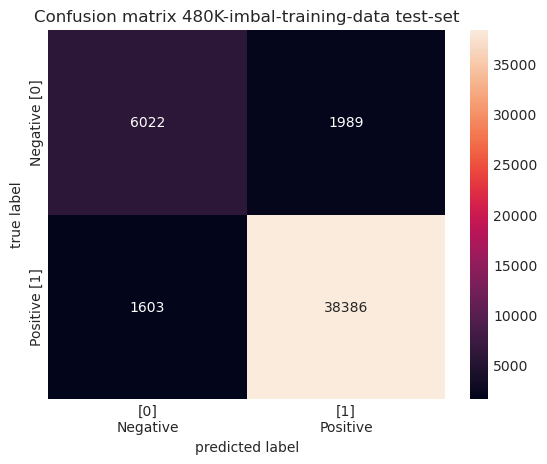

In [185]:
import matplotlib as plt
plt.style.use('seaborn-v0_8-dark')

evaluation_functions.create_confusion_matrix_graph(
    y_test,
    y_test_pred,
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'confusion_matrix_test.png'),
    show=True
)

0.7293133966603017


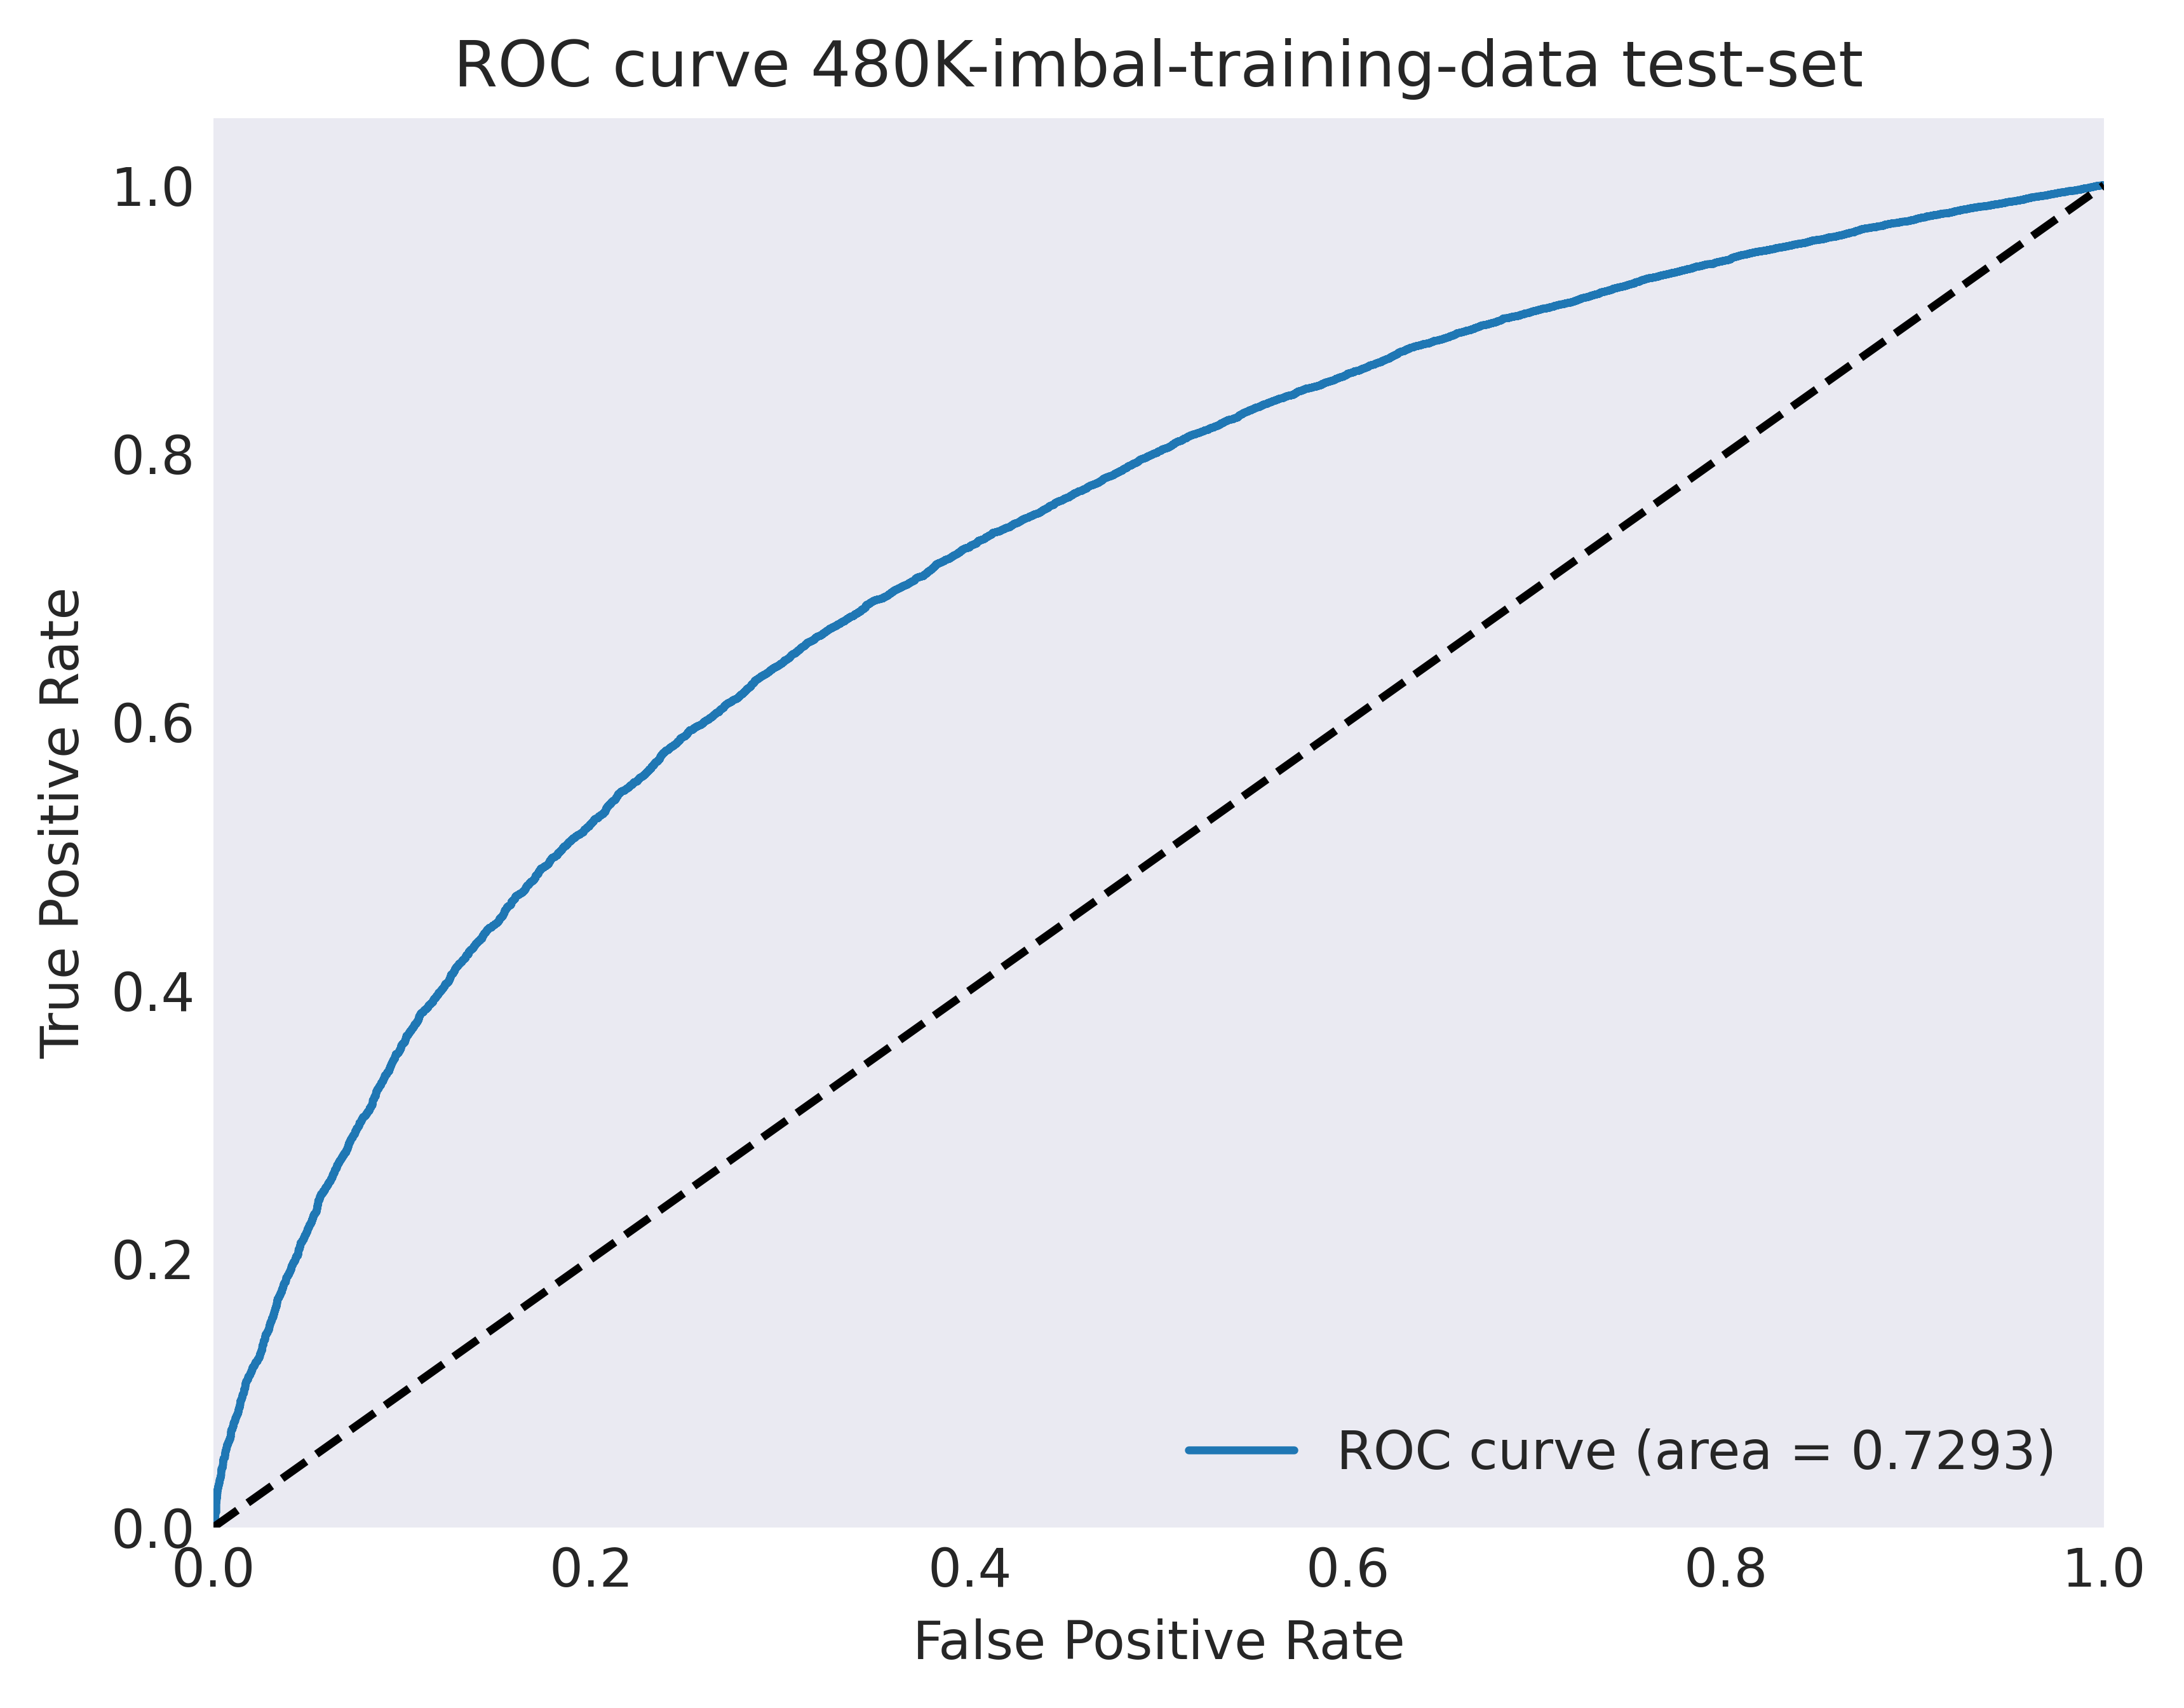

In [186]:
evaluation_functions.plot_roc_curve_binary(
    y_test,
    y_test_pred_prob,
    f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'roc_curve_test.png'),
    show=True
)

In [187]:
from sklearn.metrics import roc_auc_score

# import importlib
# importlib.reload(evaluation_functions)

# add ROC area to report_dict
test_classification_report_dict['roc_auc'] = roc_auc_score(y_test, y_test_pred_prob)

test_report_df = evaluation_functions.create_classification_report_df(
    test_classification_report_dict, 
    training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    test_report_df.to_csv(Path.joinpath(eval_test_folder, "{}_{}_test_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed balanced validation set

In [188]:
if LOAD_NUMPY_ARRAYS:
    y_bal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid_pred_prob_raw.npy'))
    y_bal_valid_pred = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid_pred.npy'))
    y_bal_valid_pred_prob = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid_pred_prob.npy'))
    y_bal_valid = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid.npy'))
else:
    y_bal_valid_pred_prob_raw = model.predict(valid_bal_dataset)

    y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

    y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                    else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

   1/2355 [..............................] - ETA: 1:16

2355/2355 [==============================] - 9s 4ms/step


In [189]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'), y_bal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'), y_bal_valid_pred)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'), y_bal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'), y_bal_valid)

In [190]:
bal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.75      0.84    150672
           1       0.79      0.96      0.87    150672

    accuracy                           0.85    301344
   macro avg       0.87      0.85      0.85    301344
weighted avg       0.87      0.85      0.85    301344



TN - True Negative 112749
FN - False Negative 6005
TP - True Positive 144667
FP - False Positive 37923
Accuracy Rate: 0.8542263990655198
Misclassification Rate: 0.1457736009344802
F1-Score: 0.8525724393672418
ROC-AUC 0.8542263990655199


In [191]:
bal_valid_classification_result_dict

{'0': {'precision': 0.9494332822473348,
  'recall': 0.7483075820324945,
  'f1-score': 0.8369570865469553,
  'support': 150672.0},
 '1': {'precision': 0.7923051645763733,
  'recall': 0.9601452160985452,
  'f1-score': 0.8681877921875282,
  'support': 150672.0},
 'accuracy': 0.8542263990655198,
 'macro avg': {'precision': 0.870869223411854,
  'recall': 0.8542263990655199,
  'f1-score': 0.8525724393672418,
  'support': 301344.0},
 'weighted avg': {'precision': 0.870869223411854,
  'recall': 0.8542263990655198,
  'f1-score': 0.8525724393672418,
  'support': 301344.0}}

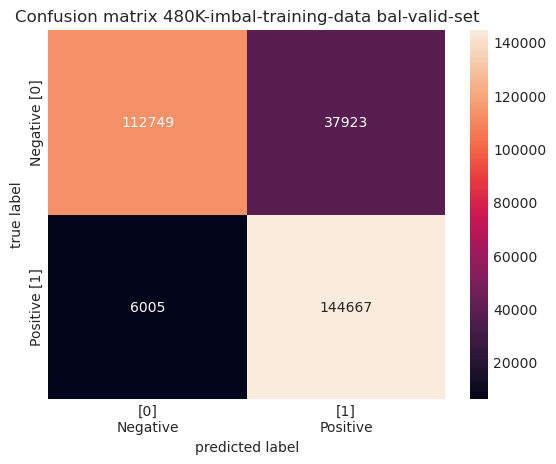

In [192]:
evaluation_functions.create_confusion_matrix_graph(
    y_bal_valid, y_bal_valid_pred, 
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'confusion_matrix_valid_bal.png'),
    show=True
)

0.7318243069366113


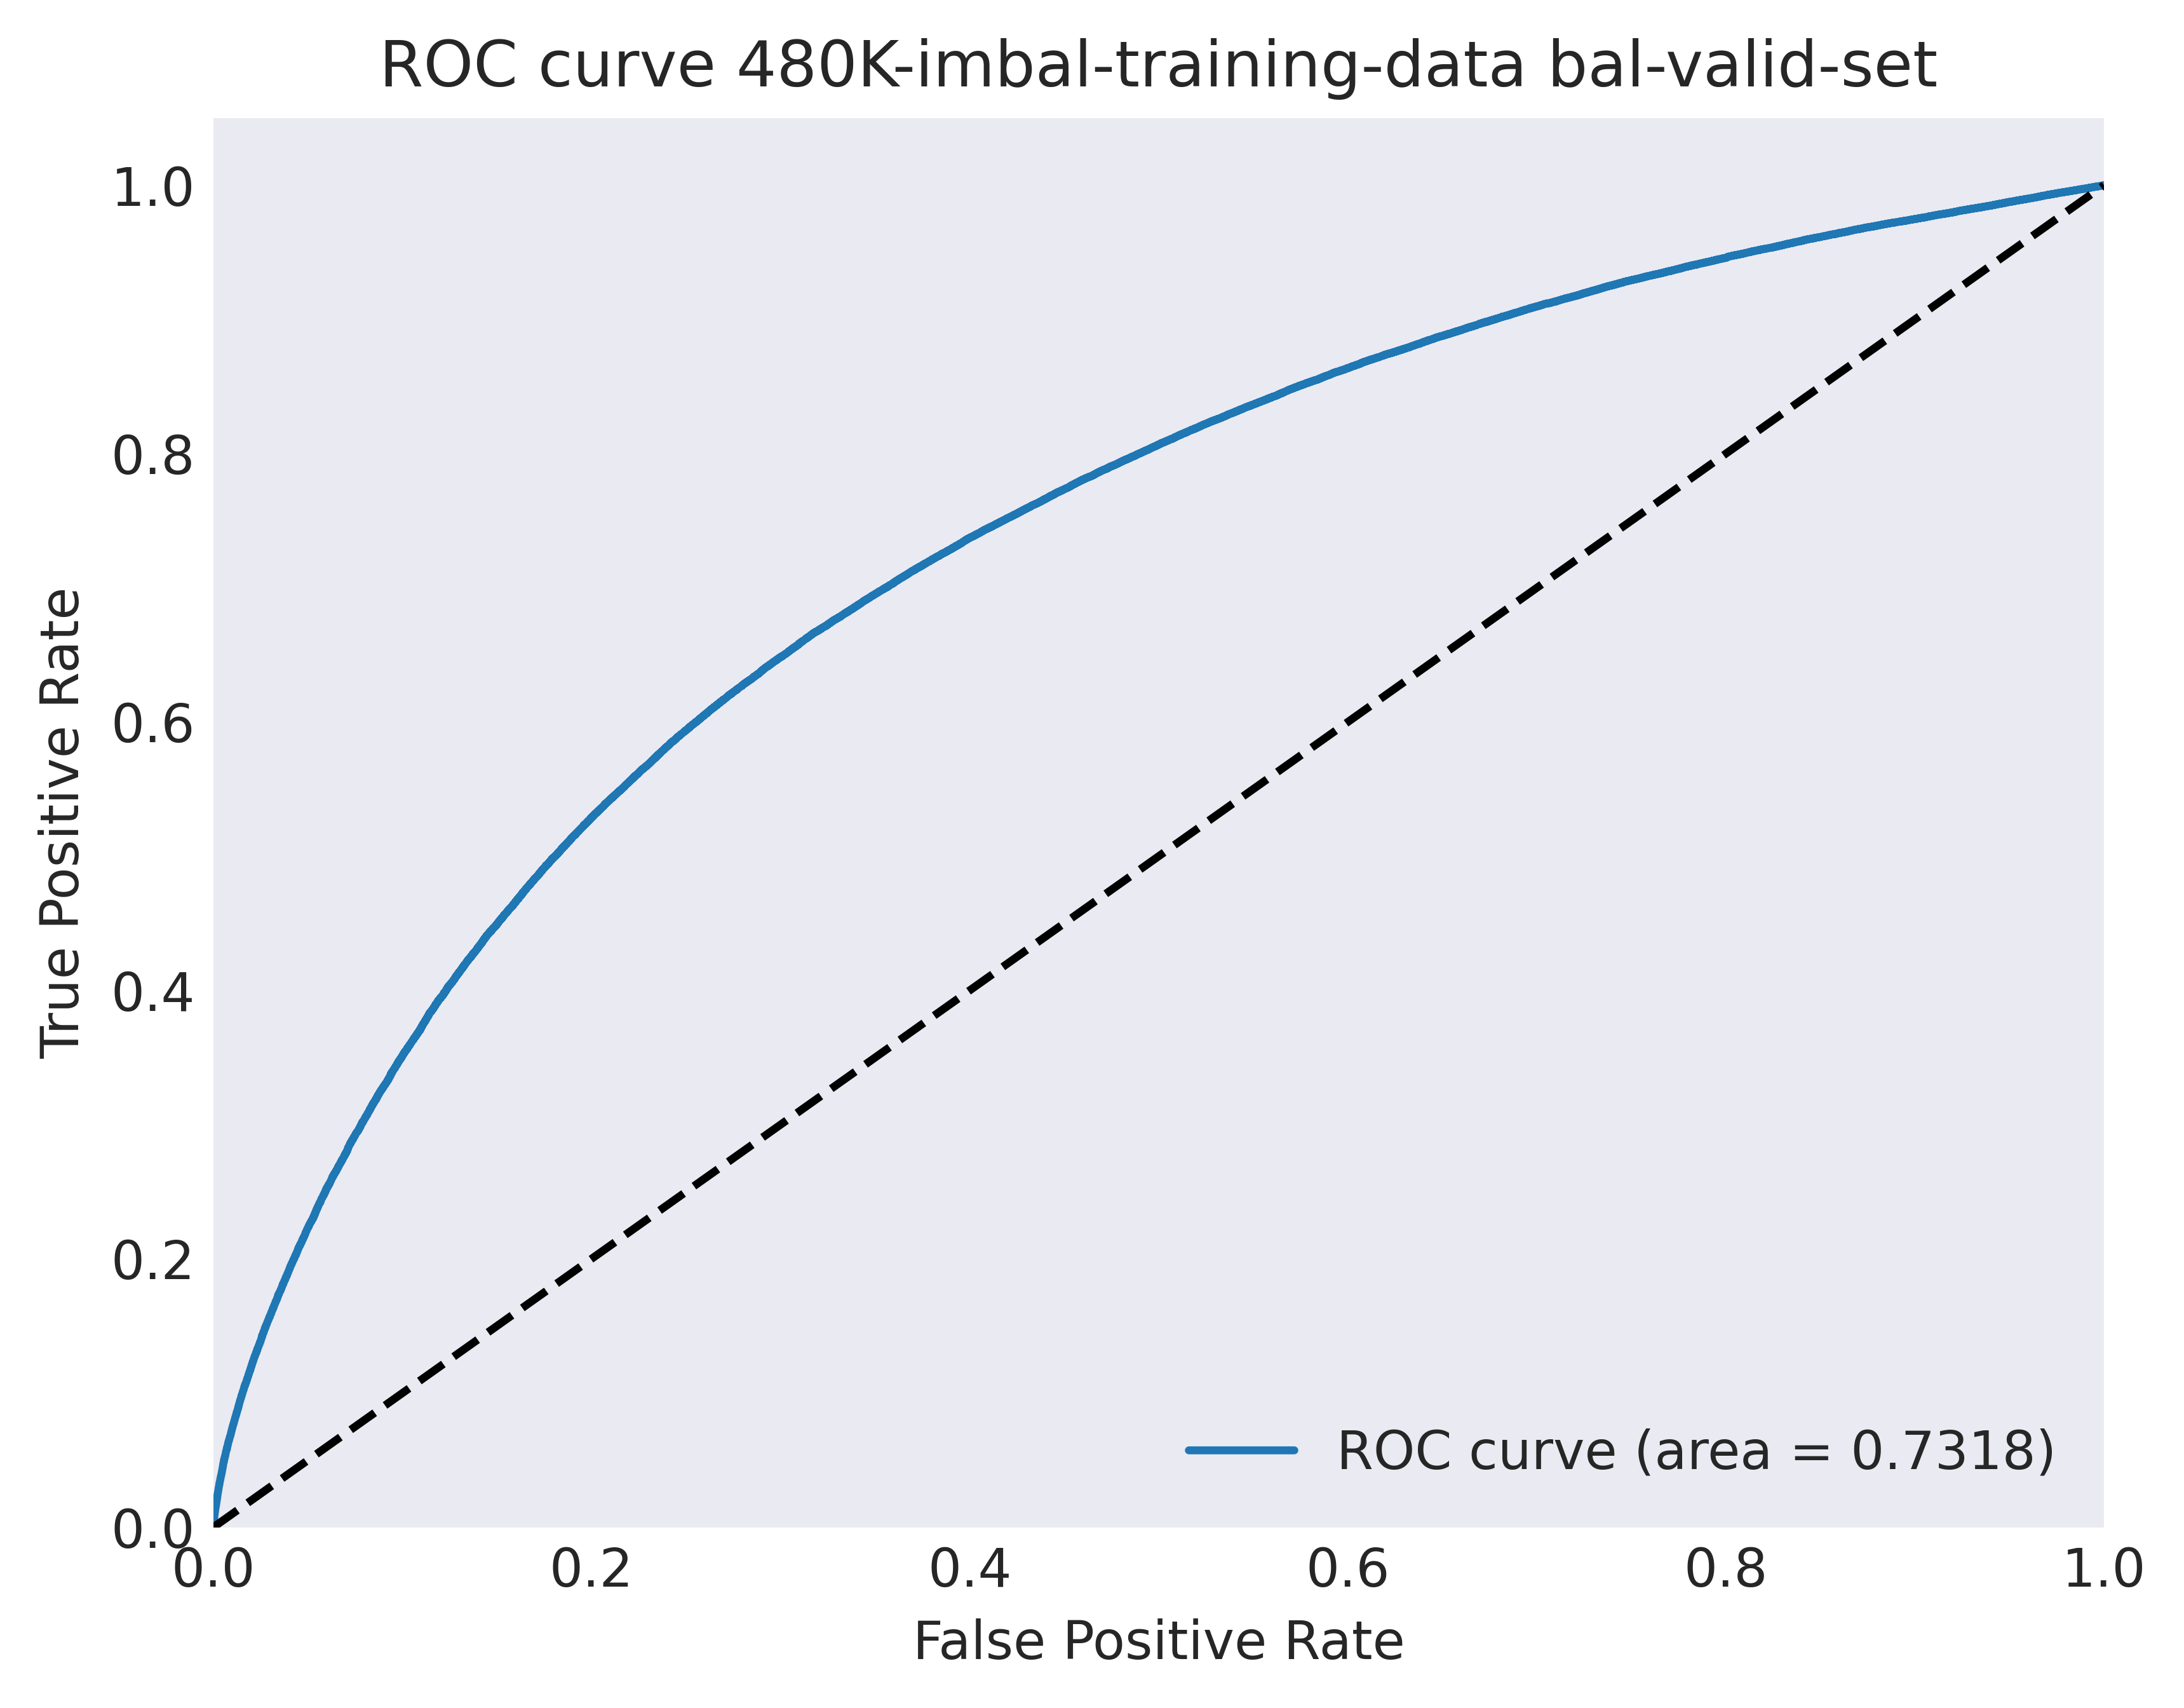

In [193]:
evaluation_functions.plot_roc_curve_binary(
    y_bal_valid, y_bal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set', 
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'roc_curve_valid_bal.png'),
    show=True
)

In [194]:
# add ROC area to report_dict
bal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_bal_valid, y_bal_valid_pred_prob)

bal_valid_report_df = evaluation_functions.create_classification_report_df(bal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    bal_valid_report_df.to_csv(Path.joinpath(eval_valid_bal_folder, "{}_{}_valid_bal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed validation set (imbalanced)

In [195]:
if LOAD_NUMPY_ARRAYS:
    y_imbal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'))
    y_imbal_valid_pred = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'))
    y_imbal_valid_pred_prob = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'))
    y_imbal_valid = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'))

else:
    y_imbal_valid_pred_prob_raw = model.predict(valid_imbal_dataset)

    y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

    y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                    else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

7229/7229 [==============================] - 26s 4ms/step


In [196]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'), y_imbal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'), y_imbal_valid_pred)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'), y_imbal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'), y_imbal_valid)

In [197]:
imbal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.75      0.76    150928
           1       0.95      0.96      0.96    774377

    accuracy                           0.92    925305
   macro avg       0.87      0.85      0.86    925305
weighted avg       0.92      0.92      0.92    925305



TN - True Negative 112792
FN - False Negative 31348
TP - True Positive 743029
FP - False Positive 38136
Accuracy Rate: 0.9249069225822837
Misclassification Rate: 0.07509307741771631
F1-Score: 0.8599233115993379
ROC-AUC 0.8534208263744211


In [198]:
imbal_valid_classification_result_dict

{'0': {'precision': 0.7825169973636742,
  'recall': 0.7473232269691509,
  'f1-score': 0.7645152981685577,
  'support': 150928.0},
 '1': {'precision': 0.9511806084501994,
  'recall': 0.9595184257796913,
  'f1-score': 0.9553313250301181,
  'support': 774377.0},
 'accuracy': 0.9249069225822837,
 'macro avg': {'precision': 0.8668488029069368,
  'recall': 0.8534208263744211,
  'f1-score': 0.8599233115993379,
  'support': 925305.0},
 'weighted avg': {'precision': 0.9236696131631674,
  'recall': 0.9249069225822837,
  'f1-score': 0.9242070132603107,
  'support': 925305.0}}

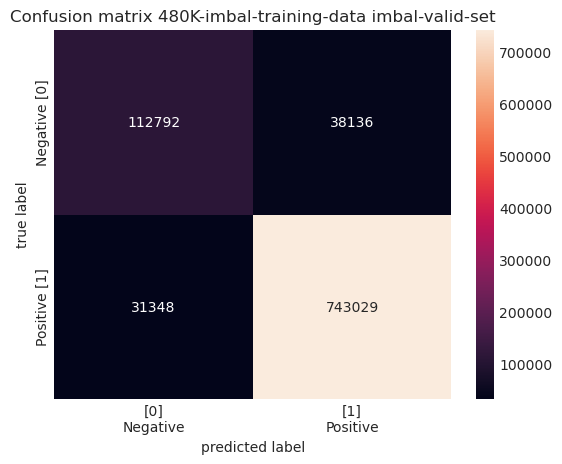

In [199]:
evaluation_functions.create_confusion_matrix_graph(
    y_imbal_valid, y_imbal_valid_pred, 
    title=f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'confusion_matrix_valid_imbal.png'),
    show=True
)

0.7321452188359469


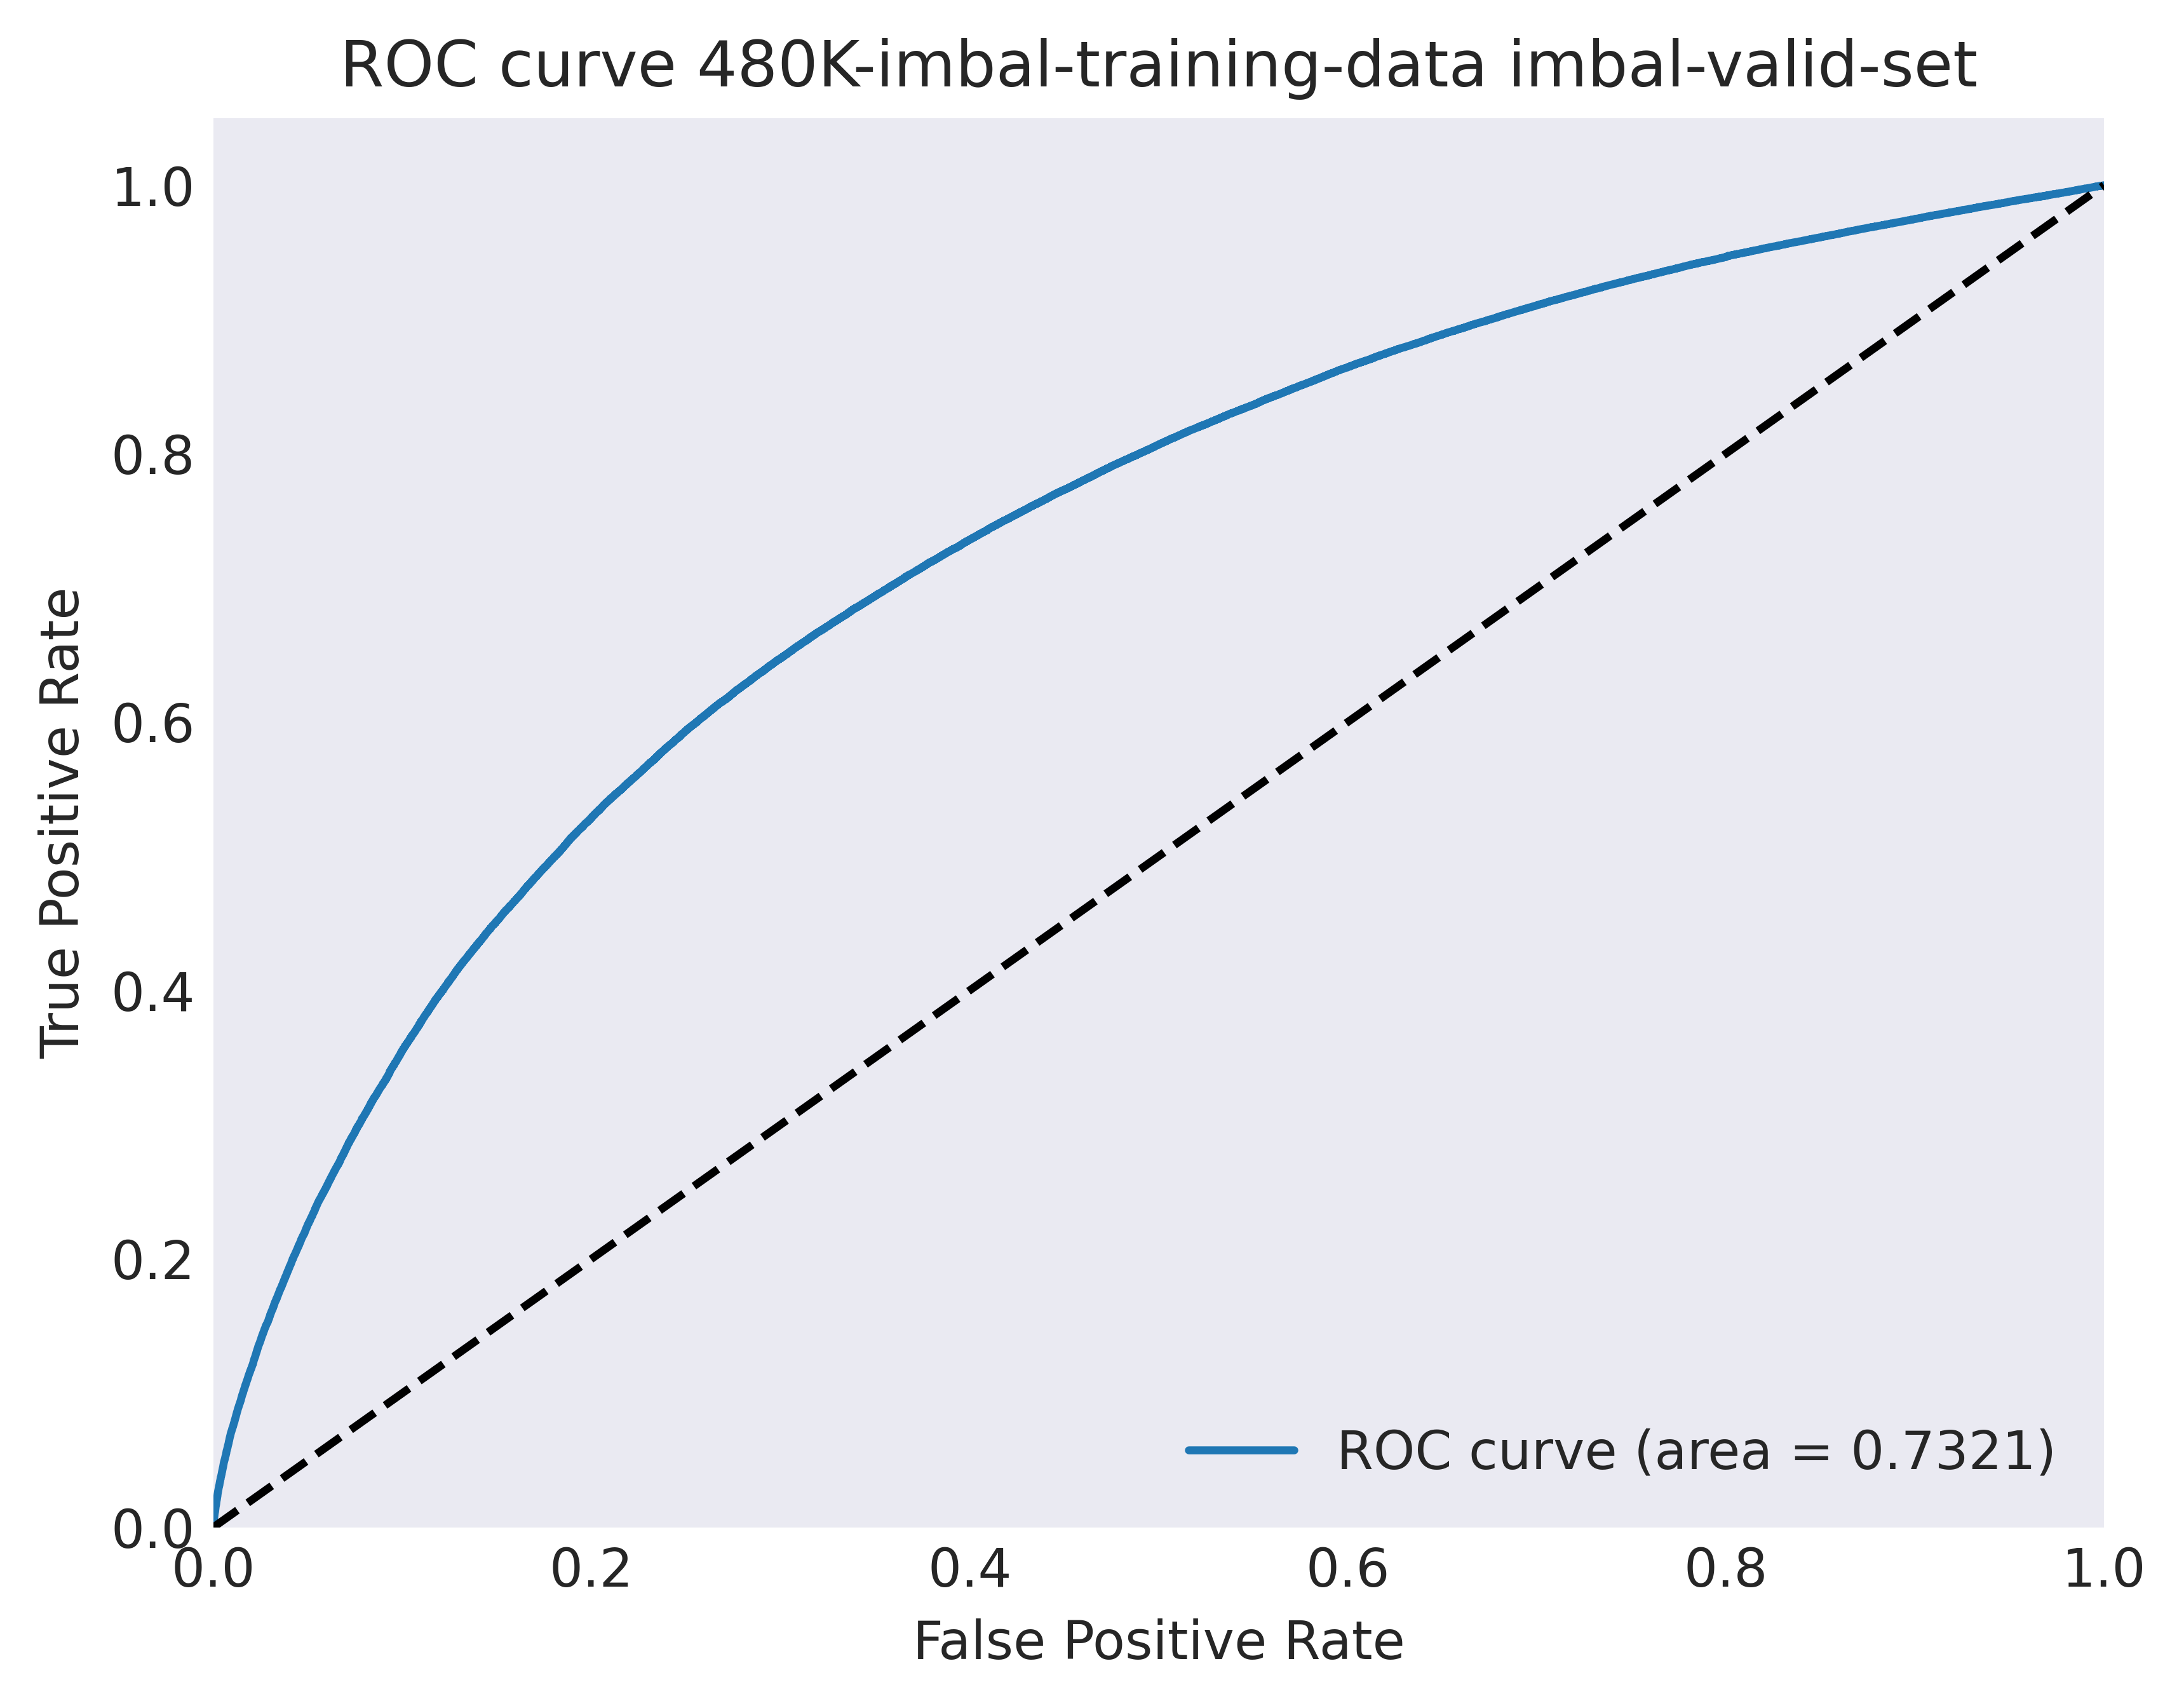

In [200]:
evaluation_functions.plot_roc_curve_binary(
    y_imbal_valid, y_imbal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'roc_curve_valid_imbal.png'),
    show=True
)

In [201]:
# add ROC area to report_dict
imbal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_imbal_valid, y_imbal_valid_pred_prob)

imbal_valid_report_df = evaluation_functions.create_classification_report_df(imbal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    imbal_valid_report_df.to_csv(Path.joinpath(eval_valid_imbal_folder, "{}_{}_valid_imbal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

Evluation end